**INITIALIZATION**
- I use these three lines of code on top of my each notebooks because it will help to prevent any problems while reloading the same project. And the third line of code helps to make visualization within the notebook.

In [1]:
#@ INITIALIZATION: 
%reload_ext autoreload
%autoreload 2
%matplotlib inline

**DOWNLOADING LIBRARIES AND DEPENDENCIES**
- I have downloaded all the libraries and dependencies required for the project in one particular cell.

In [3]:
#@ INSTALLING DEPENDENCIES: UNCOMMENT BELOW: 
# !pip install -Uqq fastbook
# import fastbook
# fastbook.setup_book()

In [20]:
#@ DOWNLOADING LIBRARIES AND DEPENDENCIES: 
from fastbook import *                                  # Getting all the Libraries. 
from fastai.callback.fp16 import *
from fastai.vision.all import *                         # Getting all the Libraries.

#@ IGNORING WARNINGS: 
import warnings
warnings.filterwarnings("ignore")

**GETTING THE DATASET**
- I will download and extract a dataset called the Oxford-IIIT Pet Dataset that contains 7349 images of cats and dogs from 37 breeds from the fast.ai datasets collection to the GPU server. I will use pretrained model that has already been trained on 1.3 million images. The pretrained model will be fine tuned using the latest advances in transfer learning to create a model that is specially customized for recognizing dogs and cats.

In [6]:
#@ GETTING THE DATASET: 
path = untar_data(URLs.PETS)/"images"                     # Path to the Images of Pets.
path.ls()                                                 # Inspecting the Path. 

(#7393) [Path('/root/.fastai/data/oxford-iiit-pet/images/newfoundland_173.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Ragdoll_177.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Maine_Coon_116.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/staffordshire_bull_terrier_141.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/British_Shorthair_89.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_207.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/scottish_terrier_50.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/japanese_chin_74.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Persian_13.jpg'),Path('/root/.fastai/data/oxford-iiit-pet/images/Russian_Blue_33.jpg')...]

**CLASS ACTIVATION MAP**
- The Class Activation Map uses the output of the last convolutional layer which is just before the average pooling layer together with predictions to give a heatmap visualization of model decision. 

In [7]:
#@ PREPARING THE DATASET:
def is_cat(x): return x[0].isupper()                      # Function to Determine Cats. 
dls = ImageDataLoaders.from_name_func(                    # Initializing Image Data Loaders. 
    path, get_image_files(path), valid_pct=0.2, seed=21,  # Getting Image Files. 
    label_func=is_cat, item_tfms=Resize(224))             # Initializing Data Loaders. 

In [9]:
#@ TRAINING THE MODEL: BASELINE MODEL: 
learn = cnn_learner(dls, resnet34, metrics=error_rate)    # Initializing Pretrained Model. 
learn.fine_tune(1)                                        # Training the Model. 

epoch,train_loss,valid_loss,error_rate,time
0,0.151146,0.022995,0.004736,01:34


epoch,train_loss,valid_loss,error_rate,time
0,0.063362,0.010456,0.004736,02:10


In [10]:
#@ INSPECTING THE DATA: 
img = PILImage.create("/content/Cat.jpg")                  # Getting a Picture of Cat. 
x, = first(dls.test_dl([img]))                             # Inspecting the Data. 

In [11]:
#@ DEFINING HOOK FUNCTION: 
class Hook():                                              # Defining the Hook Class. 
    def hook_func(self, m, i, o):                          # Defining the Hook Function. 
        self.stored = o.detach().clone()                   # Copy of the Output. 

#@ IMPLEMENTATION OF HOOK FUNCTION: 
hook_output = Hook()                                       # Initializing Hook.
hook = learn.model[0].register_forward_hook(
    hook_output.hook_func)                                 # Attaching to Neural Networks. 

#@ IMPLEMENTATION OF MODEL: 
with torch.no_grad(): output = learn.model.eval()(x)
act = hook_output.stored[0]                                # Getting Activations. 
F.softmax(output, dim=-1)                                  # Inspecting Predictions. 

tensor([[6.1430e-18, 1.0000e+00]], device='cuda:0')

In [12]:
#@ DOT PRODUCT OF WEIGHTED MATRIX: 
x.shape                                                    # Inspecting Shape of Data.
cam_map = torch.einsum('ck,kij->cij', 
                       learn.model[1][-1].weight, act)     # Initializing Dot Product. 
cam_map.shape                                              # Inspecting the Shape of Data. 

torch.Size([2, 7, 7])

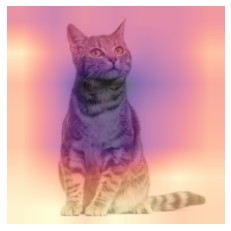

In [13]:
#@ DECODING THE IMAGES: 
x_dec = TensorImage(dls.train.decode((x,))[0][0])          # Decoding the Image. 
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map[1].detach().cpu(), alpha=0.6,
          extent=(0,224,224,0), interpolation="bilinear", 
          cmap="magma");                                   # Inspecting the Image. 

**Note:**
- The areas in bright yellow correspond to high activations and the areas in purple correspond to low activations. 

In [14]:
#@ REMOVING THE HOOK: 
hook.remove()

In [22]:
#@ DEFINING HOOK AS CONTEXT MANAGER: 
class Hook():                                                   # Defining Hook Class. 
    def __init__(self, m):                                      # Initializing Constructor Function. 
        self.hook = m.register_forward_hook(self.hook_func)     # Initializing Hook Function. 
    def hook_func(self, m, i, o):                               # Defining Hook Function. 
        self.stored = o.detach().clone()                        # Getting Copy of the Output. 
    def __enter__(self, *args): return self                     # Initializing Hook. 
    def __exit__(self, *args): self.hook.remove()               # Removing Hook. 

#@ IMPLEMENTATION OF HOOK: 
with Hook(learn.model[0]) as hook:
    with torch.no_grad(): 
        output = learn.model.eval()(x.cuda())
    act = hook.stored                                           # Getting Activations. 

**GRADIENT CAM**
- I will define a **HookBwd** class that works like **Hook** but intercepts and stores gradients instead of activations. 

In [23]:
#@ DEFINING HOOK: GRADIENTS INSTEAD OF ACTIVATIONS: 
class HookBwd():                                                # Defining Hook Class. 
    def __init__(self, m):                                      # Initializing Constructor Function. 
        self.hook = m.register_backward_hook(self.hook_func)    # Initializing Hook Function. 
    def hook_func(self, m, gi, go):                             # Defining Hook Function. 
        self.stored = go[0].detach().clone()                    # Getting Copy of the Output. 
    def __enter__(self, *args): return self                     # Initializing Hook. 
    def __exit__(self, *args): self.hook.remove()               # Removing Hook. 

#@ IMPLEMENTATION OF HOOK:
cls = 1                                                         # Initialization. 
with HookBwd(learn.model[0]) as hookg:
    with Hook(learn.model[0]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored                                       # Getting Activations. 
    output[0, cls].backward()
    grad = hookg.stored                                         # Getting Gradients. 

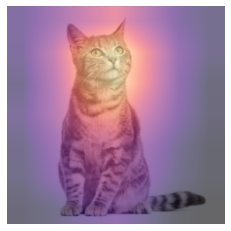

In [24]:
#@ INITIALIZING HEATMAP VISUALIZATION: 
w = grad[0].mean(dim=[1,2], keepdim=True)                       # Getting Average of Gradients. 
cam_map = (w * act[0]).sum(0)                                   # Initializing Feature Map. 
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, 
          extent=(0,224,224,0), interpolation="bilinear", 
          cmap="magma");                                        # Inspecting Heatmap Visualization. 

**Note:**
- The areas in bright yellow correspond to high activations and the areas in purple correspond to low activations. 

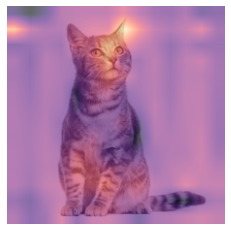

In [25]:
#@ IMPLEMENTATION OF HOOK: SECOND TO LAST LAYERS: 
cls = 1                                                         # Initialization. 
with HookBwd(learn.model[0][-2]) as hookg:
    with Hook(learn.model[0][-2]) as hook:
        output = learn.model.eval()(x.cuda())
        act = hook.stored                                       # Getting Activations. 
    output[0, cls].backward()
    grad = hookg.stored                                         # Getting Gradients. 

#@ INITIALIZING HEATMAP VISUALIZATION: 
w = grad[0].mean(dim=[1,2], keepdim=True)                       # Getting Average of Gradients. 
cam_map = (w * act[0]).sum(0)                                   # Initializing Feature Map. 
_, ax = plt.subplots()
x_dec.show(ctx=ax)
ax.imshow(cam_map.detach().cpu(), alpha=0.6, 
          extent=(0,224,224,0), interpolation="bilinear", 
          cmap="magma");                                        # Inspecting Heatmap Visualization. 